In [43]:
# Implement Layers of a Neural Net by hand
import torch
import os
import matplotlib.pyplot as plt

In [44]:
def get_absolute_directory_path(folder_name):
    current_dir = os.path.abspath(__file__)
    while not os.path.exists(os.path.join(current_dir, folder_name)):
        current_dir = os.path.dirname(current_dir)
    return os.path.join(current_dir, folder_name)

In [45]:
dataset = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(dataset))))
index_lookup_table = {index + 1: char for index, char in enumerate(chars)}
index_lookup_table[0] = '.'

# index_lookup_table

In [46]:
xenc = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=27).float()
elems = xenc.clone().detach()
print(elems)
# plt.plot(elems)


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [47]:
# invert atoi into i2c
ctoi = {c: ix + 1 for ix, c in enumerate(chars)}
itoc = {ix: c for c, ix in ctoi.items()}
itoc[0] = '.'
ctoi["."] = 0

In [62]:
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
block_size = 3  # number of characters to consider / inputs to take in, or "context"

X = []  # X is input
Y = []  # Y is the output. in test Y is the expected value

for word in dataset[:9]:
    print("================")
    print(f'Word: "{word}"')
    context = [0] * block_size  # A zero vector of size {block_size}
    for ch in word + '.':  # add a period to the end of the word, or ending buffer to know sentence/word complete
        print(f"starting context {context}")
        ix = ctoi[ch]  # convert character to index
        X.append(context)  # the input in space
        Y.append(ix)  # the output in space 
        print(f'({context} --> {ix})', '<==>', (''.join(itoc[i] for i in context), '----->', itoc[ix]))
        context = context[1:] + [ix]
        print(f"ending context {context}")
    print("================")

# X contains all the 'letters' in the dataset,  following the model of the paper, we have len(X) examples/points we want to squeeze into len(block_size)
X = torch.tensor(X) 
print(X)
Y = torch.tensor(Y)
print(Y)

Word: "yuheng"
starting context [0, 0, 0]
([0, 0, 0] --> 25) <==> ('...', '----->', 'y')
ending context [0, 0, 25]
starting context [0, 0, 25]
([0, 0, 25] --> 21) <==> ('..y', '----->', 'u')
ending context [0, 25, 21]
starting context [0, 25, 21]
([0, 25, 21] --> 8) <==> ('.yu', '----->', 'h')
ending context [25, 21, 8]
starting context [25, 21, 8]
([25, 21, 8] --> 5) <==> ('yuh', '----->', 'e')
ending context [21, 8, 5]
starting context [21, 8, 5]
([21, 8, 5] --> 14) <==> ('uhe', '----->', 'n')
ending context [8, 5, 14]
starting context [8, 5, 14]
([8, 5, 14] --> 7) <==> ('hen', '----->', 'g')
ending context [5, 14, 7]
starting context [5, 14, 7]
([5, 14, 7] --> 0) <==> ('eng', '----->', '.')
ending context [14, 7, 0]
Word: "diondre"
starting context [0, 0, 0]
([0, 0, 0] --> 4) <==> ('...', '----->', 'd')
ending context [0, 0, 4]
starting context [0, 0, 4]
([0, 0, 4] --> 9) <==> ('..d', '----->', 'i')
ending context [0, 4, 9]
starting context [0, 4, 9]
([0, 4, 9] --> 15) <==> ('.di', 

In [49]:
print(X)
print(X.shape)

print(Y)
print(Y.shape)


print(f"{X.shape}: {X.dtype}", f"{Y.shape}: {Y.dtype}")

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
torch.Size([5, 3])
tensor([ 5, 13, 13,  1,  0])
torch.Size([5])
torch.Size([5, 3]): torch.int64 torch.Size([5]): torch.int64


In [50]:
# X contains all the 'letters' in the dataset,  following the model of the paper, we have len(X) we want to squeeze into len(block_size))

## Create Hyper parameters ##
C = torch.randn((27, 2))  # embedding
# print(f'{C=}')
# print(f'{C.shape=}')

emb = C[X]  # create embedding vector from X inputs
# print(f'{emb.shape=}')
# print(f'{emb=}')

# matrix of 1 hot vectors each with input of 5 on each of the 27 neurons in this layer (by) C /embedding/
# linear matrix where the fifth input is turned on and the matrix is 27x1 length long.
# torch.nn.functional.one_hot(torch.tensor(5),num_classes=27).float() @ C

# x = 3*2, because block size is 3 and embedding is 2d
# y = any number of neurons, because we are not sure how many neurons we want to use
W1 = torch.randn((6, 100))

# biases, always equal to the number of neurons
b1 = torch.randn(100)

# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1) # wont scale 
# torch.cat(torch.unbind(emb,1),1) # scales better when inputs>3 or n inputs

# hidden layer 1
# (emb @ W1) + b1 # cant multiply 15x2 by 6x100
# hidden_layer_1_vector = emb.view(5, 6) @ W1 + b1 # cast emb to 5,6 by direct views() shape casting

hidden_layer_1_vector = emb.view(-1, 6) @ W1 + b1  # cast emb to 5,6 by using inference
hidden_layer_2_vector = torch.tan(hidden_layer_1_vector)
# print(hidden_layer_2_vector)
# print(hidden_layer_2_vector.shape)

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

# manual classification loss algorithm, bad if vector contains inputs that are not very large
# counts = logits.exp()
# prob = counts/counts.sum(1,keepdims=True)
# prob[torch.arange(5),Y] # pick next char, x should be number of letters in dataset
# loss = -prob[torch.arange(5),Y].log().mean() # nll

# classification loss algorithm (cross_entropy)
# used because can handle large inputs over our manual implementation 
# loss = torch.nn.functional.cross_entropy(logits, Y)


In [51]:
# construct a set of learning rates to iterate over and fine the best learning rate for our model
lre = torch.linspace(-3, 0, 10000)  # create 1000 learning rates between 10^-3 and 10^0
lrs = 10 ** lre  # convert to 10^x to get between 0 and 1

lri = []
lossi = []
stepi = []

C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

# print(sum(p.nelement() for p in parameters)) # total elements in all parameters
# print(any(p is None for p in parameters)) # No parameters are None

In [52]:
# Track operations for backpropagation
for parameter in parameters:
    parameter.requires_grad = True

for _ in range(10000):
    ### iterate over whole data set ###############
    # # forward pass of the model
    # emb = C[X]
    # h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    # logits = h @ W2 + b2  # output of layer2
    # 
    # ## Tuning ##
    # loss = torch.nn.functional.cross_entropy(logits, Y)
    # for parameter in parameters: # zero gradients
    #     parameter.grad = None
    # loss.backward() # backpropagation
    # for parameter in [C, W1, b1, W2, b2]: # update weights
    #     parameter.data += -0.1 * parameter.grad
    # =============================================================

    ## iterate over mini batch ####################
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass of the model
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2

    ## Tuning ## 
    loss = torch.nn.functional.cross_entropy(logits, Y[ix])
    # print(f'loss={loss.item()}')
    for parameter in parameters:  # zero gradients
        parameter.grad = None
    loss.backward()  # backpropagation
    lr = lrs[_]  # for plotting purposes
    lr = 0.1  # check graph to find best learning rate 10^-1
    for parameter in [C, W1, b1, W2, b2]:  # update weights
        parameter.data += -lr * parameter.grad
    # =============================================================

    # track stats
    lri.append(lre[_])
    stepi.append(_)
    # lossi.append(loss.item())
    lossi.append(loss.log10().item())

print(f'loss post-optimize={loss.item()}')

loss post-optimize=2.5681812985567376e-05


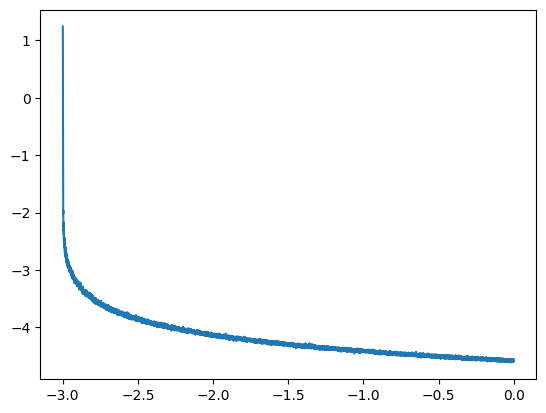

In [57]:
# plt.plot(lri,lossi)
plt.plot(stepi, lossi)

In [54]:
def build_dataset(dataset):
    block_size = 3  # number of characters to consider / inputs to take in

    X = []  # X is input
    Y = []  # Y is the output. in test Y is the expected value

    for word in dataset:
        context = [0] * block_size  # A zero vector of size {block_size}
        for ch in word + '.':  # add a period to the end of the word, or ending buffer to know sentence/word complete
            ix = ctoi[ch]  # convert character to index
            X.append(context)  # the input in space
            Y.append(ix)  # the output in space 
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(dataset)
n1 = int(0.8 * len(dataset))
n2 = int(0.9 * len(dataset))

# training, dev/validation, test
# 80% training, 10% dev, 10% test
X_train, Y_train = build_dataset(dataset[:n1])
X_dev, Y_dev = build_dataset(dataset[n1:n2])
X_test, Y_test = build_dataset(dataset[n2:])


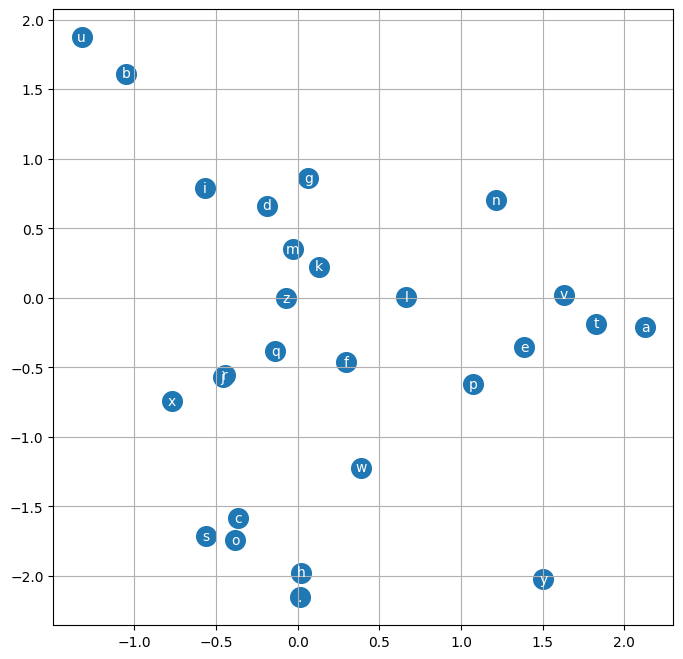

In [55]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(27):
    plt.text(C[i, 0].item(), C[i, 1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid('minor')


In [56]:
g = torch.Generator().manual_seed(2147483647)

def neural_net_algorithm(
        seed_generator,
):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # (1, block_size,d)
        logits = h @ W2 + b2
        probs = torch.nn.functional.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=seed_generator).item() # sample
        context = context[1:] + [ix]
        if ix == 0:
            break
    return ''.join(itoc[i] for i in out)


# Sample NueroNet
neural_net_algorithm(g)

''